# Time Series Analysis and Forecasting of Household Electricity Consumption

This notebook presents a comprehensive time series analysis of household electricity consumption data. 
The objective is to explore temporal patterns by extracting meaningful information from datetime data, 
analyze trend and seasonality using multiple techniques, and build a forecasting model using the ARIMA approach. 
The workflow follows best practices for time series analysis, including proper datetime handling, 
aggregation to reduce noise, statistical validation of stationarity, and evaluation of forecast performance.


In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pmdarima as pm

plt.style.use('default')


## Load Dataset

The dataset is semicolon-separated and contains missing values
represented by '?' which are converted to NaN during loading.


In [61]:
df = pd.read_csv(
    'household_power_consumption.txt',
    sep=';',
    na_values=['?']
)

df.head()


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [62]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    float64
 3   Global_reactive_power  float64
 4   Voltage                float64
 5   Global_intensity       float64
 6   Sub_metering_1         float64
 7   Sub_metering_2         float64
 8   Sub_metering_3         float64
dtypes: float64(7), object(2)
memory usage: 142.5+ MB


### Dataset Summary

- The dataset contains over 2 million observations.
- Multiple numerical variables represent electricity consumption.
- Date and Time columns must be combined for time series analysis.


## Datetime Processing

Date and Time columns are combined into a single datetime feature
to enable time-based indexing and analysis.


In [63]:
df['Datetime'] = pd.to_datetime(
    df['Date'] + ' ' + df['Time'],
    dayfirst=True
)

df.drop(['Date', 'Time'], axis=1, inplace=True)


## Sorting and Indexing

The dataset is sorted chronologically and indexed by datetime.


In [64]:
df.sort_values('Datetime', inplace=True)
df.set_index('Datetime', inplace=True)

df = df.asfreq('min')  # minute-level frequency
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


## Handling Missing Values

Forward fill is used to handle short gaps in sensor readings.


In [65]:
df.ffill(inplace=True)


## Datetime Feature Extraction (Exploratory Analysis)

Additional features are extracted from the datetime index to understand
temporal patterns such as daily, weekly, and monthly behavior.
These features are used only for exploratory analysis and are not
directly used as inputs to the ARIMA model.


In [66]:
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['weekday'] = df.index.weekday
df['hour'] = df.index.hour

df[['year', 'month', 'day', 'weekday', 'hour']].head()


,year,month,day,weekday,hour
Datetime,,,,,
2006-12-16 17:24:00,2006,12,16,5,17
2006-12-16 17:25:00,2006,12,16,5,17
2006-12-16 17:26:00,2006,12,16,5,17
2006-12-16 17:27:00,2006,12,16,5,17
2006-12-16 17:28:00,2006,12,16,5,17


## Exploratory Analysis (Minute-Level Data)

A visualization of minute-level data is used to inspect
raw volatility in electricity consumption.


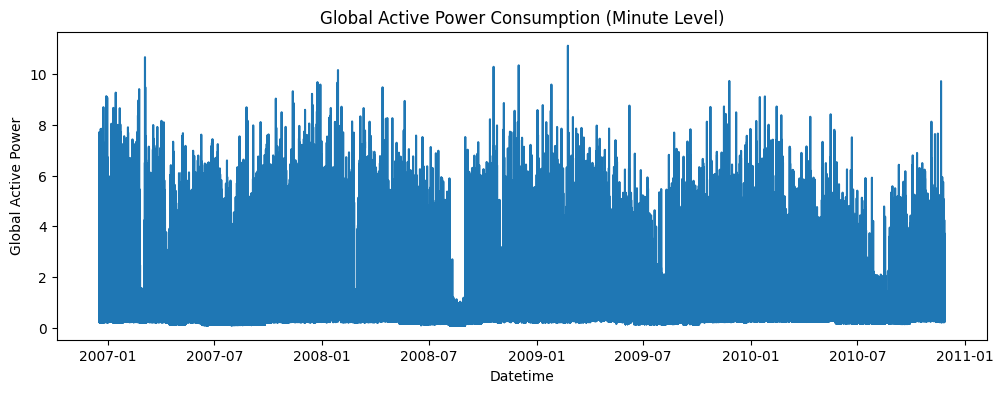

In [67]:
plt.figure(figsize=(12, 4))
plt.plot(df['Global_active_power'])
plt.title('Global Active Power Consumption (Minute Level)')
plt.xlabel('Datetime')
plt.ylabel('Global Active Power')
plt.show()


### Key Inference
The minute-level series is highly volatile and noisy,
making it unsuitable for direct statistical modeling
without aggregation.


## Resampling to Daily Frequency

Daily aggregation is performed to reduce noise and
highlight long-term trends and seasonality.


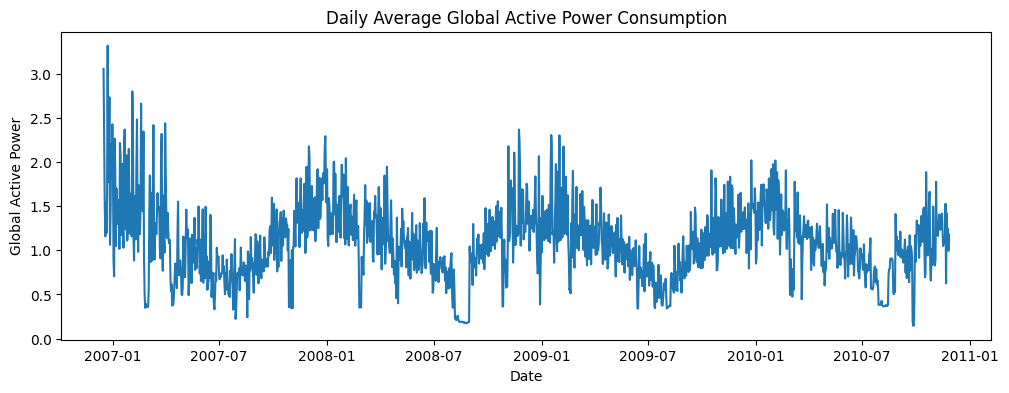

In [68]:
daily_power = df['Global_active_power'].resample('D').mean()

plt.figure(figsize=(12, 4))
plt.plot(daily_power)
plt.title('Daily Average Global Active Power Consumption')
plt.xlabel('Date')
plt.ylabel('Global Active Power')
plt.show()


### Key Inference
Daily aggregation smooths short-term fluctuations and
reveals clearer trend and seasonal patterns, making
the data suitable for forecasting.


## Seasonal Decomposition

The daily series is decomposed into trend, seasonal,
and residual components using a weekly period.


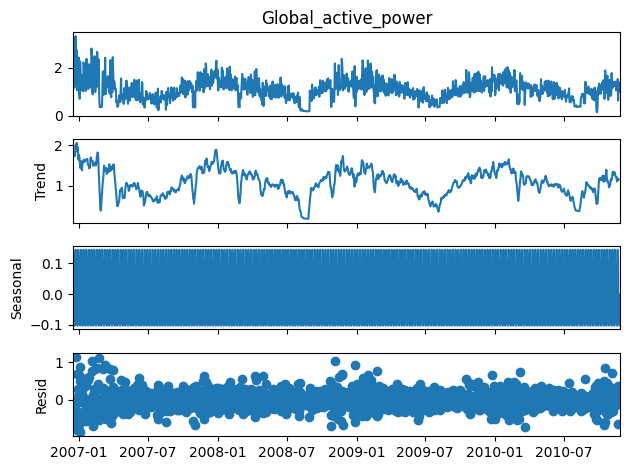

In [69]:
decomposition = seasonal_decompose(
    daily_power,
    model='additive',
    period=7
)

decomposition.plot()
plt.show()


### Key Inference
The decomposition confirms a strong weekly seasonal component,
supporting the use of a seasonal ARIMA model.


## Stationarity Check

The Augmented Dickey-Fuller test is used to assess
whether the series is stationary.


In [70]:
def adf_test(series):
    result = adfuller(series.dropna())
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])

adf_test(daily_power)


ADF Statistic: -3.7347586808460145
p-value: 0.0036499731073697393


## Train–Test Split

A chronological split is applied to prevent data leakage.
The final 30 days are reserved as the test set.


In [71]:
train = daily_power.iloc[:-30]
test = daily_power.iloc[-30:]


## Model Training (Auto-ARIMA)

Auto-ARIMA is used to automatically select optimal
ARIMA and seasonal parameters.
A weekly seasonal cycle (m = 7) is used.


In [72]:
model = pm.auto_arima(
    train,
    seasonal=True,
    m=7,
    trace=False,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1412
Model:             SARIMAX(0, 1, 2)x(1, 0, [1], 7)   Log Likelihood                -258.767
Date:                             Tue, 30 Dec 2025   AIC                            527.534
Time:                                     15:31:34   BIC                            553.794
Sample:                                 12-16-2006   HQIC                           537.347
                                      - 10-27-2010                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6010      0.020    -30.083      0.000      -0.640      -0.562
ma.L2         -0.2106      0.020    -10.774      0.000      -0.249      -0.172
ar.S.L7        0.9821      0.006    158.887      0.000       0.970       0.994
ma.S.L7       -0.9095      0.017    -55.053      0.000      -0.942      -0.877
sigma2         0.0842      0.002     36.144      0.000       0.080       0.089
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):               253.45
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               0.48   Skew:                             0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Forecasting

The trained model is used to forecast electricity consumption
for the next 30 days.


In [73]:
forecast, conf_int = model.predict(
    n_periods=len(test),
    return_conf_int=True
)

forecast_series = pd.Series(forecast, index=test.index)


## Model Evaluation

Forecast accuracy is evaluated using
MAE and RMSE.


In [74]:
mae = mean_absolute_error(test, forecast_series)
rmse = np.sqrt(mean_squared_error(test, forecast_series))

mae, rmse


(0.1832668156103898, np.float64(0.24057606055041872))

## Forecast Visualization

Actual and forecasted values are compared along with
confidence intervals to represent uncertainty.


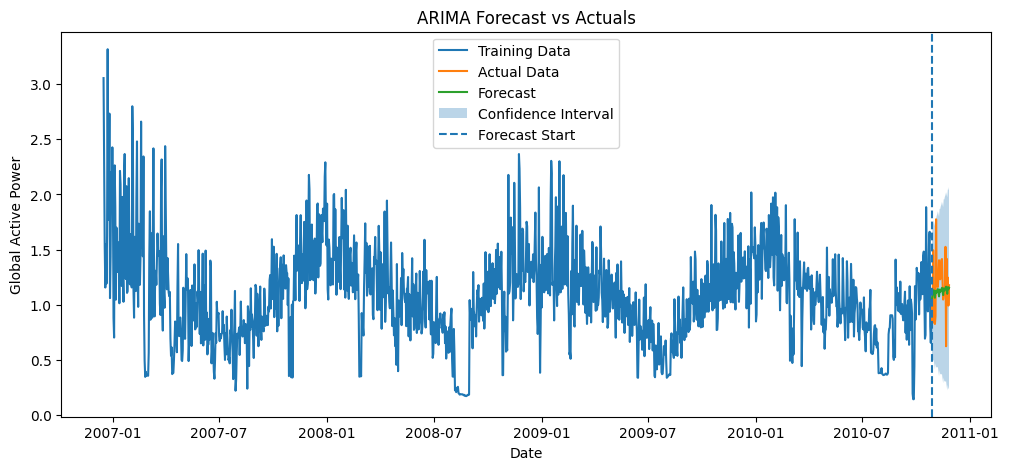

In [75]:
plt.figure(figsize=(12, 5))

plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Actual Data')
plt.plot(forecast_series.index, forecast_series, label='Forecast')

plt.fill_between(
    test.index,
    conf_int[:, 0],
    conf_int[:, 1],
    alpha=0.3,
    label='Confidence Interval'
)

plt.axvline(test.index[0], linestyle='--', label='Forecast Start')
plt.legend()
plt.title('ARIMA Forecast vs Actuals')
plt.xlabel('Date')
plt.ylabel('Global Active Power')
plt.show()


### Key Inference
The model captures trend and weekly seasonality effectively.
Prediction uncertainty increases as forecasts extend
further into the future, which is expected in time series forecasting.


## Conclusion

This notebook presents a structured time series analysis of household electricity consumption data. 
Datetime features were extracted to understand temporal patterns, and trend and seasonality were analyzed using aggregation and seasonal decomposition. 
A seasonal ARIMA model was applied to forecast daily electricity consumption, and the results were evaluated using MAE and RMSE. 
The analysis demonstrates a clear and interpretable approach to time series forecasting.
